<a href="https://colab.research.google.com/github/ttya16/kaggle_LANL_Earthquake_Prediction/blob/master/kaggle_LANL_eq_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#kaggleコンペのデータをダウンロードするための準備
!pip install kaggle
!pip install numpy==1.16.0 #numpy.quantileを使いたいため

     |████████████████████████████████| 17.3MB 21.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3


In [0]:
#import data files from kaggle
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3024           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11423            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4588           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         37           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3135           False  
recognizing-faces-in-the-wild                      2019-08-01 23:59:00  Playground       Knowledge      

In [0]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 31.3MB/s]
 97% 234M/242M [00:01<00:00, 125MB/s]
100% 242M/242M [00:01<00:00, 132MB/s]
 99% 2.01G/2.03G [00:15<00:00, 163MB/s]
100% 2.03G/2.03G [00:16<00:00, 134MB/s]


In [0]:
#Downloadした訓練用ファイルを展開
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
#Colaboratoryで使われているGPUを確認 (optional)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7f2ab08b-dfb9-9bf8-6fde-16c6dfc6c389)


## データセットについて考える
まずはtrain.csvの中身を見てみる。

In [0]:
import numpy as np
import pandas as pd

In [0]:
%%time
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
data_len = len(train_df)

CPU times: user 2min 9s, sys: 31.7 s, total: 2min 40s
Wall time: 2min 47s


In [0]:
print(train_df.shape)
train_df.head()

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


6億2914万5480件の、
* **acoustic_data**(地震波の大きさを計測した値, int16,単位:voltageとあるのでおそらく電圧)
* **time_to_failure"**(次の地震発生までの時間, float32, 単位:秒)
<br>

からなっている。


プロットしてみると以下のようになる。<br>
※全件プロットしようとするとセッションがクラッシュするので、控えめに。。<br>
とりあえず以下では頭の7500000件分のデータをプロットしてみる。
<br>おそらくmatplotlib.pyplotでのプロットの方が速い。seaborn遅い


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Acoustic Data and TTF over time.')

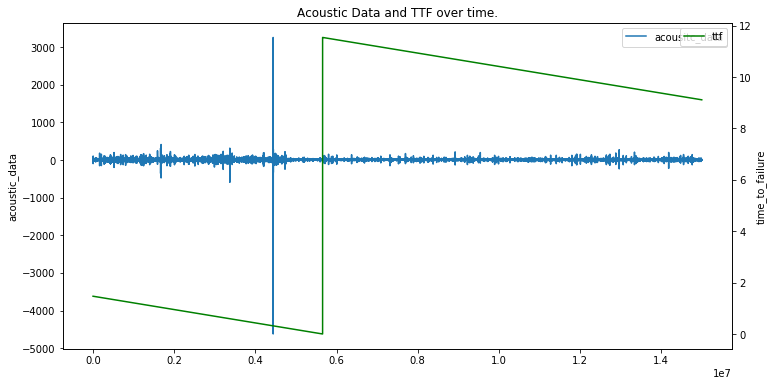

In [0]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
sns.lineplot(x=train_df[:7500000].index, y=train_df["acoustic_data"][:7500000], ax=ax1, label="acousitc_data")
ax1.legend()
ax2 = ax1.twinx()
sns.lineplot(x=train_df[:7500000].index, y=train_df["time_to_failure"][:7500000], ax=ax2, color="g", label="ttf")
ax2.legend()
plt.title("Acoustic Data and TTF over time.")



プロット結果より、
* acoustic_dataは細かい範囲で振動を繰り返しており、地震発生時にはその振れが一段と大きくなっている様子が見て取れる。また、地震発生前後で見比べると平均的な振れ幅の大きさにも変化があるように見える。

* time_to_failureは時間経過と共にほぼ一定の割合で減少しているように見られ、地震発生より若干遅れてリセットされている。おそらく「地震発生」→「次の地震までの時間を計算」の処理のラグ？と推測される。(discussionのどこかで情報があったかもしれない)

という点が分かる。


また、全件プロットすると分かることだが、trainデータには計16件の地震発生イベントが含まれている。


In [0]:
train_df["acoustic_data"][:7500000].describe()

count    7.500000e+06
mean     4.511330e+00
std      2.043296e+01
min     -4.621000e+03
25%      2.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      3.252000e+03
Name: acoustic_data, dtype: float64

頭7500000件分のデータのacoustic_dataの簡単な統計量。<br>
平均4.5、標準偏差20.4、第1四分位数=2、中央値=4、第3四分位数=7、最小値=-4621、最大値3252である。<br>
平均と中央値はほぼ一緒だが、やや右よりの分布になっているのかなといった感触。
<br>全体で見るとまた違ってくるかもしれない。
↓一応ヒストグラムをプロットした結果

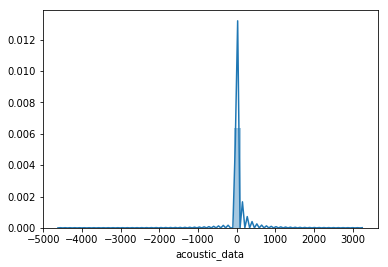

In [0]:
sns.distplot(a=train_df["acoustic_data"][:7500000], kde=True)

### データセットの由来（どうやって測定したのか）
KaggleのDiscussion [Introduction]("https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525"), [Additional Info]("https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526")に説明あり。

運営コメより<br>
*The data for this challenge comes from a classic laboratory earthquake experiment, that has been studied in depth as a tabletop analog of seismogenic faults for decades. A number of physical laws widely used by the geoscience community have been derived from this earthquake machine.*

* 実験室における擬似的に地震発生させる装置で測定したデータ
* 地震波の大きさは4096個の圧電セラミックセンサーにより測定され、各センサー間には12マイクロ秒の測定間隔がある。

これを踏まえてtime_to_failureについて、地震イベントを含まない区間で推移をみてみる。

41
0.0000001192秒の差
149
0.0000001192秒の差
258
0.0000001192秒の差
366
0.0000001192秒の差
474
0.0000001192秒の差
583
0.0000001192秒の差
691
0.0000001192秒の差
799
0.0000001192秒の差
908
0.0000001192秒の差
1016
0.0000001192秒の差
1125
0.0000001192秒の差
1233
0.0000001192秒の差
1341
0.0000001192秒の差
1450
0.0000001192秒の差
1558
0.0000001192秒の差
1666
0.0000001192秒の差
1775
0.0000001192秒の差
1883
0.0000001192秒の差
1991
0.0000001192秒の差
2100
0.0000001192秒の差
2208
0.0000001192秒の差
2317
0.0000001192秒の差
2425
0.0000001192秒の差
2533
0.0000001192秒の差
2642
0.0000001192秒の差
2750
0.0000001192秒の差
2858
0.0000001192秒の差
2967
0.0000001192秒の差
3075
0.0000001192秒の差
3184
0.0000001192秒の差
3292
0.0000001192秒の差
3400
0.0000001192秒の差
3509
0.0000001192秒の差
3617
0.0000001192秒の差
3725
0.0000001192秒の差
3834
0.0000001192秒の差
3942
0.0000001192秒の差
4051
0.0000001192秒の差
4095
0.0009955168秒の差
4179
0.0000001192秒の差
4288
0.0000001192秒の差
4396
0.0000001192秒の差
4504
0.0000001192秒の差
4613
0.0000001192秒の差
4721
0.0000001192秒の差
4830
0.0000001192秒の差
4938
0.0000001192秒の差


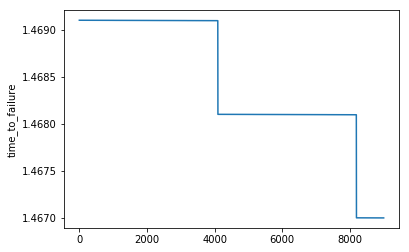

In [0]:
ttf_small=train_df["time_to_failure"][:9000]

for i, ttf in enumerate(ttf_small[:5000]):
  if i == 0: continue
  if ttf_small[i-1] != ttf:
    print(i)
    print("{:.10f}秒の差".format(ttf_small[i-1] - ttf))
sns.lineplot(x=ttf_small.index, y=ttf_small)

細かく見ると108~9件ごとに0.11μsずつ減っている。<br>
が、introductionにあったように4096番目のセンサの出力後にはおよそ1msの差(機器の測定誤差)が観測できる。

(改めて見るとかなり大きな情報損失のような感じがする・・・)

### 4096個のセンサ内にも測定の個体差がある？（kambarakun）
センサの個体差を見つけられれば独立で使用できる。
<br>つまり、4096個のセンサのうち1個まともそうな奴を選んでそのセンサの観測結果のみを用いて特徴量に当てはめていくことができたりするかも？

testの並び替えにも使えるかも？


検証中...


In [0]:
sensor_df = pd.DataFrame()
#4096のセンサごとにacoustic_dataを分ける

for i in range(100):
  for sid in range(4096):
    sensor_df.loc[i, "sensor_id" + str(sid) ] = train_df["acoustic_data"][sid + 4096*i]　
    
sensor_df.head()

#たまに4096じゃなくて4095でギャップがある箇所があるらしいので、単純に4096区切りでやるとどこかでずれる
#4095の時はどのセンサで欠損しているか不明なので無視するのが良いか

,sensor_id0,sensor_id1,sensor_id2,sensor_id3,sensor_id4,sensor_id5,sensor_id6,sensor_id7,sensor_id8,sensor_id9,...,sensor_id4086,sensor_id4087,sensor_id4088,sensor_id4089,sensor_id4090,sensor_id4091,sensor_id4092,sensor_id4093,sensor_id4094,sensor_id4095
0,12.0,6.0,8.0,5.0,8.0,8.0,9.0,7.0,-5.0,3.0,...,-16.0,-7.0,3.0,7.0,10.0,12.0,8.0,6.0,3.0,-13.0
1,-15.0,-7.0,-7.0,-3.0,1.0,3.0,2.0,-3.0,-1.0,1.0,...,-3.0,-1.0,-4.0,2.0,11.0,14.0,17.0,19.0,17.0,-2.0
2,4.0,1.0,5.0,8.0,13.0,10.0,10.0,10.0,9.0,4.0,...,1.0,1.0,2.0,5.0,6.0,4.0,3.0,3.0,10.0,-4.0
3,2.0,3.0,9.0,3.0,6.0,6.0,3.0,0.0,3.0,8.0,...,10.0,9.0,9.0,10.0,9.0,2.0,6.0,11.0,0.0,0.0
4,10.0,7.0,8.0,8.0,8.0,6.0,6.0,5.0,0.0,1.0,...,2.0,-1.0,1.0,6.0,10.0,7.0,4.0,3.0,10.0,3.0


In [0]:
sensor_mean = sensor_df.mean()
print(sensor_mean)

In [0]:
#del train_df
del sensor_df

## 問題設定&アプローチ
本コンペの問題設定としては以下のようになっている。
* テスト用のデータは1セグメント150000件（0.0375秒$\times$4.0MHz）の地震波データ毎で用意されており、<br>今回の目標は各セグメント終了時のTTFを推測するモデルを作ることである。

* 精度の評価はMAE(平均絶対値誤差)による。
$$
MAE = \frac{\sum_{i=1}^{n}{|y_i - \hat{y_i}|}}{n}
$$


よって、アプローチとしては
* まずtrainデータをtestデータ同様に150000件毎のセグメントで区切る。
* セグメント毎に有効そうな特徴量をいくつか用意して計算する。<br>
すなわちセグメントがn個(seg1$\dots$n)、特徴量がm個(特徴量1$\dots$m)の場合、用意する特徴量行列は以下のようになる。


$$
    \boldsymbol{
        \begin{array}{c|ccc}
            {} & 特徴量1 & \cdots & 特徴量m \\
            seg_1 & \hline \\
             \vdots & \vdots  & \vdots & \vdots \\
             seg_n & {} & {} & {} \\
        \end{array}}
$$
* 特徴量行列が用意できたらモデルを定義する。<br>
本コンペはセグメント毎のTTF(秒数)を推測するのが目的なので、回帰問題として捉えるのが妥当と考えられるので、RandomForest系の機械学習モデル(LightGBM, XGBoost)やニューラルネットモデルを試してみる。


* モデルが定義できたら学習を進めて、validationスコアを見つつパラメータ調整して仕上げていく。
<br>→LightGBMによるアプローチはkambarakunに委ねた


### 時系列データだから時系列解析的なアプローチもあり？
この問題においておそらく最も重要な点は「**地震発生後のTTFの値を正しく推測できるか**」と考えられる。<br>TTFは基本的には始点（地震発生直後に計算される次の地震発生までの秒数）が求まればそこから0になるまではシンプルに減っていく一方のはずである。<br>
ではTTFはどうやって決まるのかを考えた時、「直前の地震の大きさ」「過去の地震発生頻度」「過去の地震波の大きさ変動」などが関係しそうと予測を立てられる。つまり**過去の情報をある程度考慮できるようなモデル**を設計することで精度が良くなるのではないかと考えられる。
<br>
ここではRNNのモデルも設計してみて、時系列データとして解析するアプローチも検証してみる。

## 特徴量行列を作る

### 予兆シグナル検出用の閾値として分位点の値を設定

[関連研究]("https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2017GL074677&file=grl56367-sup-0001-supinfo.pdf")
によると、地震イベント発生が近づくと観測される地震波の数値も大きな変動を見せるとある。<br>そこで閾値をいくつか設定して、セグメント内の地震波のうち閾値以上が観測された割合を予兆の度合いとして特徴付けることにしてみる。

In [0]:
#thresholds for precursors
"""
今回はいくつか適当な分位数を閾値として設定してみた。
"""
precursor_thresholds = []


precursor_thresholds.append(np.quantile(train_df['acoustic_data'], 0.0001))
precursor_thresholds.append(np.quantile(train_df['acoustic_data'], 0.0005))
precursor_thresholds.append(np.quantile(train_df['acoustic_data'], 0.9995))
precursor_thresholds.append(np.quantile(train_df['acoustic_data'], 0.9999))



print(precursor_thresholds)

[-150.0, -66.0, 76.0, 161.0]


In [0]:
#train_dfもういらないので消しておく。
del train_df

### 特徴量生成の為の関数
1.基本的な統計量たち。
<br>平均、標準偏差、最小値、最大値・・・説明略
<br>**歪度**: 分布の偏り度合いを示す
<br>**尖度**: 分布の尖具合を示す。（前提として分布が単峰でないとあんまり有用じゃなかった気がするが。。一応）
<br>
<br>2.分位数を細かく取得。これは[関連研究]("https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2017GL074677&file=grl56367-sup-0001-supinfo.pdf")の取り方を参考にした。

<br>3.予兆シグナル。閾値として適当に全体の分位数を設定し、それより大きい（負の場合は小さい）値のacoustic_dataの割合を計算する。
閾値の設定方法以外は[関連研究]("https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2017GL074677&file=grl56367-sup-0001-supinfo.pdf")と同じ方法で計算出来ているはず。。

<br>4.segmentの両端N件を切り取って、その区間の統計量を計算する。kaggleのkernel由来。<br>
segmentの端の情報を強調することで、前後のsegmentに対する情報量を増やせないかといったアイデアだろう。


<br>5.時系列データに対する窓関数的な処理で特徴量を計算。時系列データであるが故の有用な性質を見出すためのオーソドックスなアプローチ。
以下では移動平均と移動標準偏差を採用。（kaggleのkernelみていると移動平均よりも移動stdの方が特徴量的に有用そう）


<br>6.その他気になったやつ。
* IQR(inter quantile range)＝四分位範囲。第3四分位-第2四分位でデータの散らばり範囲を示す。



In [0]:
#190327 measure for precursor using threshold and Heaviside step func
def threshold_measure(x, theta):
  if theta > 0:
    d = x - theta
  else:
    d = -x + theta
  return np.array([0 if di < 0 else 1 for di in d]).mean()

#change_rate計算(Andrewのkernelより拝借)
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

#特徴量を用意する
def gen_features(X, thresholds):
  from scipy.stats import kurtosis, skew
  
  strain = pd.Series()
  X_len = len(X)
  
  """1.基本的な統計量"""
  strain["mean"] = X.mean()
  strain["std"] = X.std()
  strain["kurtosis"] = X.kurtosis()
  strain["skew"] = X.skew()
  strain["max"] = X.max()
  strain["min"] = X.min()
  strain["abs_max"] = abs(X).max()
  strain["mean_chang_rate"] = calc_change_rate(X)
  
  
  """2.分位点を0.01刻みで取得"""
  for i in range(10):
    col_name_quantile1 = "q" + str(i*0.01)
    col_name_quantile2 = "q" + str(1.0 - 0.01*i)
    strain[col_name_quantile1] = np.quantile(X, 0.01*i)
    strain[col_name_quantile2] = np.quantile(X, 1.0 - 0.01*i)
  
  """3.予兆シグナルの割合"""
  for th in thresholds:
    col_name_th = "threshold_" + str(th)
    strain[col_name_th] = threshold_measure(X, th)
    
  """4.端何件かだけで統計量を計算"""
  edge_rows = 30000
  strain["mean_head"+str(edge_rows)] = X[:edge_rows].mean()
  strain["std_head"+str(edge_rows)] = X[:edge_rows].std()
  strain["min_head"+str(edge_rows)] = X[:edge_rows].min()
  strain["max_head"+str(edge_rows)] = X[:edge_rows].max()
  strain["skew_head+"+str(edge_rows)] = X[:edge_rows].skew()
  strain["kurtosis_head+"+str(edge_rows)] = X[:edge_rows].kurtosis()
  strain["mean_change_rate_head"+str(edge_rows)] = calc_change_rate(X[:edge_rows])
  
  strain["mean_tail"+str(edge_rows)] = X[-edge_rows:].mean()
  strain["std_tail"+str(edge_rows)] = X[-edge_rows:].std()
  strain["min_tail"+str(edge_rows)] = X[-edge_rows:].min()
  strain["max_tail"+str(edge_rows)] = X[-edge_rows:].max()
  strain["skew_tail"+str(edge_rows)] = X[-edge_rows:].skew()
  strain["kurtosis_tail"+str(edge_rows)] = X[-edge_rows:].kurtosis()
  strain["mean_change_rate_tail"+str(edge_rows)] = calc_change_rate(X[-edge_rows:])
  
  
  """5.rolling windowsごとの特徴量を計算する。ここではchunkの1000分の1"""
  window_size = X_len//1000
  X_roll_std = X.rolling(window_size).std().dropna().values
  X_roll_mean = X.rolling(window_size).mean().dropna().values
  
  strain["X_roll_mean_avg"] = X_roll_mean.mean()
  strain["X_roll_mean_std"] = X_roll_mean.std()
  strain["X_roll_mean_min"] = X_roll_mean.min()
  strain["X_roll_mean_max"] = X_roll_mean.max()
  strain["q01_roll_mean"] = np.quantile(X_roll_mean, 0.01)
  strain["q05_roll_mean"] = np.quantile(X_roll_mean, 0.05)
  strain["q95_roll_mean"] = np.quantile(X_roll_mean, 0.95)
  strain["q99_roll_mean"] = np.quantile(X_roll_mean, 0.99)
  
  strain["X_roll_std_avg"] = X_roll_std.mean()
  strain["X_roll_std_std"] = X_roll_std.std()
  strain["X_roll_std_min"] = X_roll_std.min()
  strain["X_roll_std_max"] = X_roll_std.max()
  strain["q01_roll_std"] = np.quantile(X_roll_std, 0.01)
  strain["q05_roll_std"] = np.quantile(X_roll_std, 0.05)
  strain["q95_roll_std"] = np.quantile(X_roll_std, 0.95)
  strain["q99_roll_std"] = np.quantile(X_roll_std, 0.99)
  
  """6.その他気になったやつ"""
  strain["iqr"] = np.subtract(*np.percentile(X, [75, 25]))
      
  return strain

#test用
def gen_features_nn(X):
  strain = pd.Series()
  X_len = len(X)
  
  strain["mean"] = X.mean()
  strain["std"] = X.std()
  
  return strain

### trainデータをchunkごとに読み込んで、特徴量を計算し、モデルの学習用データとして用意する。

testデータの1ファイルが150000件のデータからなるchunkで用意されている一方、<br>trainデータは連続なsequenceデータなので、trainを150000件区切りで読んで、それぞれ特徴量を計算してpreprocessする。

In [0]:
chunksize = 150000
train = pd.read_csv("train.csv", iterator=True, chunksize=chunksize, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()
c = 0
print("Start preprocessing...")
for chunk in train:
  c += 1
  df = df.append(chunk)
  if len(df) >= chunksize:
    df = df[-chunksize:]
    ch = gen_features(df['acoustic_data'], thresholds=precursor_thresholds)
    #ch = gen_features_nn(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    preprocessed_portion = (X_train.shape[0]*chunksize*100)/data_len
    if c % 100 == 0:
      print("\r" + str(round(preprocessed_portion, 1)) + "% done." + "="*int(preprocessed_portion/10)+">" + " "*(10- int(preprocessed_portion/10))+"||", end="")
      
print("\r" + "100% done." + "="*10 + ">"+ "||", end="")

Start preprocessing...
100% done.==========>||

In [0]:
print(X_train.shape)
X_train.head()

(4195, 63)


,X_roll_mean_avg,X_roll_mean_max,X_roll_mean_min,X_roll_mean_std,X_roll_std_avg,X_roll_std_max,X_roll_std_min,X_roll_std_std,abs_max,iqr,kurtosis,kurtosis_head+30000,kurtosis_tail30000,max,max_head30000,max_tail30000,mean,mean_chang_rate,mean_change_rate_head30000,mean_change_rate_tail30000,mean_head30000,mean_tail30000,min,min_head30000,min_tail30000,q0.0,q0.01,q0.02,q0.03,q0.04,q0.05,q0.06,q0.07,q0.08,q0.09,q0.91,q0.92,q0.9299999999999999,q0.94,q0.95,q0.96,q0.97,q0.98,q0.99,q01_roll_mean,q01_roll_std,q05_roll_mean,q05_roll_std,q1.0,q95_roll_mean,q95_roll_std,q99_roll_mean,q99_roll_std,skew,skew_head+30000,skew_tail30000,std,std_head30000,std_tail30000,threshold_-150.0,threshold_-66.0,threshold_161.0,threshold_76.0
0,4.883790,8.560000,1.546667,0.397393,4.074231,51.002358,2.097575,3.074653,104.0,4.0,33.662481,33.165839,2.022456,104.0,104.0,26.0,4.884113,0.036138,0.019228,0.021605,5.011700,4.508067,-98.0,-98.0,-16.0,-98.0,-8.0,-5.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0,0.0,10.0,10.0,11.0,11.0,11.0,12.0,13.0,15.0,18.0,3.926667,2.382224,4.220000,2.535617,104.0,5.506667,8.326547,5.773333,17.218036,-0.024061,-0.129510,0.047550,5.101106,7.367779,3.766104,0.000000,0.000093,0.000000,0.000100
1,4.725525,12.293333,-1.306667,0.394606,4.473657,80.993965,2.165584,4.854929,181.0,5.0,98.758517,98.145824,68.727069,181.0,181.0,111.0,4.725767,0.022629,0.034917,0.034537,4.646933,4.776367,-154.0,-154.0,-115.0,-154.0,-11.0,-6.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0,10.0,10.0,11.0,11.0,12.0,12.0,14.0,16.0,21.0,3.840000,2.388043,4.140000,2.528310,181.0,5.293333,9.964860,5.560000,22.884040,0.390561,0.585039,-0.340063,6.588824,8.111482,5.842718,0.000013,0.000580,0.000027,0.000580
2,4.906059,10.493333,-0.466667,0.432219,4.960900,48.471274,2.166452,4.909991,140.0,5.0,33.555211,29.762751,21.361429,140.0,97.0,140.0,4.906393,0.023744,0.025152,-0.012051,4.644500,5.157133,-106.0,-87.0,-106.0,-106.0,-15.0,-9.0,-6.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,11.0,11.0,11.0,12.0,13.0,14.0,15.0,19.0,26.0,3.893333,2.456876,4.233333,2.598778,140.0,5.560000,13.597738,5.966667,29.405621,0.217391,-0.024459,0.321789,6.967397,6.623311,10.701517,0.000000,0.000327,0.000000,0.000373
3,4.901918,13.760000,-2.240000,0.461750,4.567832,101.524085,2.006265,5.215045,199.0,5.0,116.548172,14.079172,31.115635,197.0,75.0,84.0,4.902240,0.042462,0.038677,0.057941,4.858567,5.005800,-199.0,-48.0,-79.0,-199.0,-12.0,-6.0,-4.0,-3.0,-2.0,-1.0,-1.0,-1.0,0.0,10.0,10.0,11.0,11.0,12.0,13.0,14.0,16.0,22.0,3.933333,2.422444,4.240000,2.549869,197.0,5.520000,10.095455,5.833333,25.745944,0.757278,0.401829,-0.273932,6.922305,5.740348,5.745648,0.000033,0.000507,0.000087,0.000607
4,4.909241,10.900000,-0.073333,0.447178,4.794287,67.665151,2.064941,5.524425,145.0,5.0,52.977905,37.617602,58.981714,145.0,93.0,128.0,4.908720,0.038659,0.051415,0.052366,4.891000,4.786633,-126.0,-96.0,-126.0,-126.0,-15.0,-8.0,-5.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0,10.0,11.0,11.0,11.0,12.0,13.0,15.0,18.0,26.0,3.913333,2.378699,4.320000,2.543765,145.0,5.533333,12.250051,6.093333,34.931312,0.064531,-0.195779,-0.445644,7.301110,5.938768,7.592349,0.000000,0.000640,0.000000,0.000633


In [0]:
np.abs(X_train.corrwith(pd.Series(y_train.values))).sort_values(ascending=False).head(12)

q05_roll_std                  0.646821
q01_roll_std                  0.641634
mean_chang_rate               0.538835
iqr                           0.507208
mean_change_rate_tail30000    0.488803
mean_change_rate_head30000    0.486741
q0.91                         0.461815
q0.92                         0.449282
q0.09                         0.445394
q0.9299999999999999           0.437616
q0.08                         0.434877
q95_roll_std                  0.434453
dtype: float64

### Scalingとtrain_test_split

In [0]:
#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

#学習データと検証データに分割
from sklearn.model_selection import train_test_split

X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = train_test_split(X_train_sc, y_train, test_size=0.1,shuffle=False)

print(X_tr_sc.shape)
print(y_tr_sc.shape)

(3775, 63)
(3775,)


In [0]:
#model作るのにkerasから必要なものをimport
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNLSTM, CuDNNGRU, Dropout, BatchNormalization, Bidirectional
n_features = X_tr_sc.shape[1]

Using TensorFlow backend.


In [0]:
#LSTM, GRUのモデルに対応した形に入力するデータをreshape
X_tr_reshaped = np.reshape(np.array(X_tr_sc), (X_tr_sc.shape[0], 1, X_tr_sc.shape[1]))
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))

## モデルを作る

考慮したポイント<br>
* train lossが下がってもvalidationスコアが良くならない(overfitting)問題がある。今回の場合[問題設定](https://colab.research.google.com/drive/1ZT9dpQnaCqSHThLIWZWcmBcB85DvgpQN#scrollTo=vve7XBj1n77b&line=26&uniqifier=1)でもポイントアウトしたように、地震発生後のTTFを如何に正確に予測できるかが肝であると考える。
逆に言うと、ここを外せばその分誤差も大きくなって、モデルが修正するのも難しくなってくるだろう。<br>
ところがtrainデータには16件しか地震発生イベントがなく、学習データとしては如何せん少なすぎるため、モデルが過学習してしまう可能性が非常に高い。<br>

一つ試したのが、モデルの活性化関数を性質の異なるものを組み合わせることである。<br>
NNでは一般的にはreluが最もパフォーマンスに優れているが、これのみで実装すると（主に地震発生直後の）TTF予測が大きく外れた際に誤差に大きく影響が出てしまう。
そこで以下のhard_sigmoid関数を出力レイヤ側に設定して、大きくなりすぎた予測値をカットしてしまうように出来ないか試してみた。

* **hard sigmoid**<br>
以下の式で表される活性化関数の一種。<br>
通常のsigmoidは滑らかなのに対して、hard sigmoidはカクカクしている。
<br>
$$
f(x) =
\begin{cases}
            0 \quad (x < -2.5) \\
            0.2x+0.5 \quad (-2.5 \leqq x \leqq 2.5)  \\
            1 \quad (x > 2.5)
        \end{cases}
$$

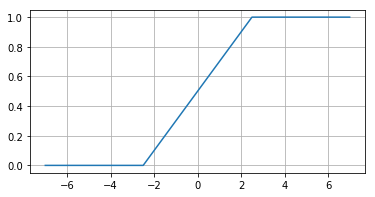

In [0]:
def HSigmoid(x):
  if x < -2.5:
    return 0
  elif x > 2.5:
    return 1
  else:
    return 0.2*x + 0.5
  
sample_x = np.arange(-7, 7, 0.01)
sample_y = [HSigmoid(x) for x in sample_x]
plt.figure(figsize=(6, 3))

plt.plot(sample_x, sample_y)
plt.grid(True)
plt.show()

### LSTM model
LSTMモデル。
系列データ特有の過去の値を考慮した予測が可能
* **CuDNNLSTMレイヤ** : GPU環境で使えるGRUレイヤ。素のGRUレイヤよりも高速処理ができる。

In [0]:
#LSTM

model_lstm = Sequential()
model_lstm.add(CuDNNLSTM(256, return_sequences = True, input_shape=(None, n_features)))
model_lstm.add(CuDNNLSTM(64))
model_lstm.add(Dense(1024, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(128, activation='hard_sigmoid'))
model_lstm.add(Dense(10, activation='hard_sigmoid'))
model_lstm.add(BatchNormalization())
#model.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 256)         328704    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dens

In [0]:
#compile & train bidirectional RNN model
from keras.optimizers import adam
model_lstm.compile(optimizer = adam(lr=0.00075), loss='MAE')
model_lstm.fit(X_tr_reshaped, y_tr_sc, epochs=50, batch_size=50, verbose=1,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3397 samples, validate on 378 samples
Epoch 1/50
3397/3397 [==============================] - 7s 2ms/step - loss: 5.5035 - val_loss: 7.2758
Epoch 2/50
3397/3397 [==============================] - 1s 217us/step - loss: 5.2094 - val_loss: 6.9155
Epoch 3/50
3397/3397 [==============================] - 1s 218us/step - loss: 4.8538 - val_loss: 6.6491
Epoch 4/50
3397/3397 [==============================] - 1s 220us/step - loss: 4.4041 - val_loss: 6.6753
Epoch 5/50
3397/3397 [==============================] - 1s 218us/step - loss: 3.8786 - val_loss: 6.3313
Epoch 6/50
3397/3397 [==============================] - 1s 211us/step - loss: 3.2703 - val_loss: 5.4134
Epoch 7/50
3397/3397 [==============================] - 1s 219us/step - loss: 2.6840 - val_loss: 4.7962
Epoch 8/50
3397/3397 [==============================] - 1s 222us/step - loss: 2.3037 - val_loss: 3.8809
Epoch 9/50
3397/3397 [==============================] - 1s 214us/step - los

LSTM 1.9942324285240565


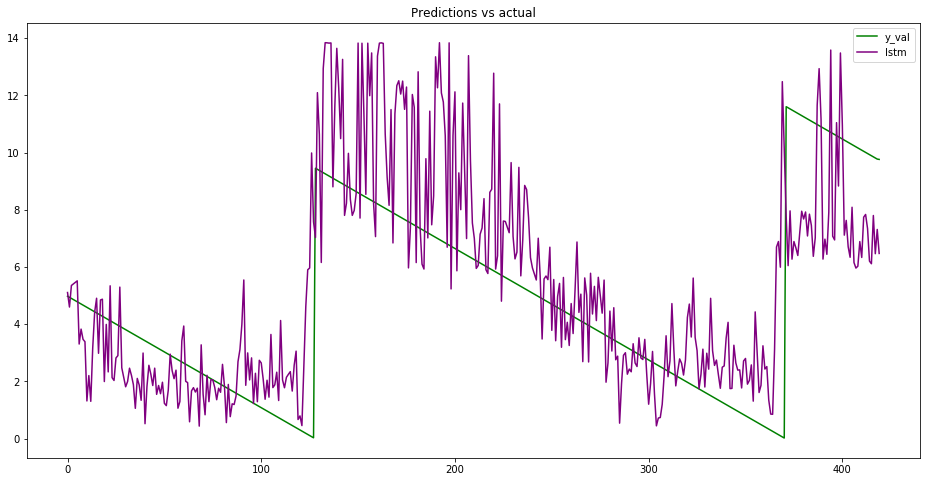

In [0]:
from sklearn.metrics import mean_absolute_error
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))

y_pred_lstm = model_lstm.predict(X_val_reshaped)
val_error_lstm = mean_absolute_error(y_val_sc, y_pred_lstm)
print("LSTM", val_error_lstm)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(np.array(y_val_sc), color='g', label='y_val')
plt.plot(y_pred_lstm, color='purple', label='lstm')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### GRU
過去→未来の方向のみ考慮したモデル。過去の情報もある程度考慮して学習をする。
* **CuDNNGRUレイヤ** : GPU環境で使えるGRUレイヤ。素のGRUレイヤよりも高速処理ができる。

In [0]:
#GRU

model_gru = Sequential()
model_gru.add(CuDNNGRU(256, return_sequences = True, input_shape=(None, n_features)))
model_gru.add(CuDNNGRU(64))
model_gru.add(Dense(1024, activation='relu'))
model_gru.add(Dense(512, activation='relu'))
model_gru.add(Dense(256, activation='relu'))
model_gru.add(Dense(128, activation='hard_sigmoid'))
model_gru.add(Dense(10, activation='hard_sigmoid'))
model_gru.add(BatchNormalization())
#model.add(Dropout(0.2))
model_gru.add(Dense(1))

model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 256)         246528    
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                61824     
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
__________

In [0]:
#compile & train RNN model
from keras.optimizers import adam
model_gru.compile(optimizer = adam(lr=0.00075), loss='MAE')
model_gru.fit(X_tr_reshaped, y_tr_sc, epochs=50, batch_size=50, verbose=1, validation_split=0.05)

Train on 3586 samples, validate on 189 samples
Epoch 1/50
3586/3586 [==============================] - 2s 460us/step - loss: 5.5233 - val_loss: 8.1184
Epoch 2/50
3586/3586 [==============================] - 1s 143us/step - loss: 5.2334 - val_loss: 8.6535
Epoch 3/50
3586/3586 [==============================] - 1s 142us/step - loss: 4.8391 - val_loss: 7.6619
Epoch 4/50
3586/3586 [==============================] - 0s 139us/step - loss: 4.3221 - val_loss: 9.3644
Epoch 5/50
3586/3586 [==============================] - 1s 147us/step - loss: 3.6799 - val_loss: 7.8560
Epoch 6/50
3586/3586 [==============================] - 1s 142us/step - loss: 2.9898 - val_loss: 6.9209
Epoch 7/50
3586/3586 [==============================] - 1s 147us/step - loss: 2.4411 - val_loss: 5.3776
Epoch 8/50
3586/3586 [==============================] - 1s 141us/step - loss: 2.1850 - val_loss: 4.9601
Epoch 9/50
3586/3586 [==============================] - 1s 143us/step - loss: 2.0670 - val_loss: 4.4845
Epoch 10/50
3586/

GRU 2.3258658459083916


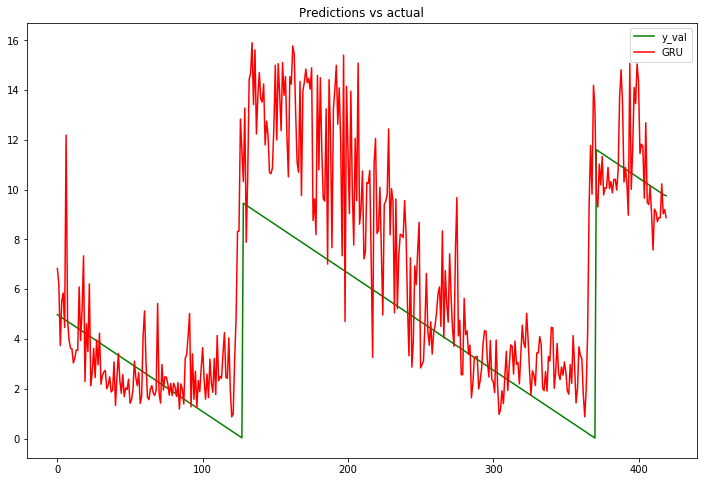

In [0]:
from sklearn.metrics import mean_absolute_error
X_val_reshaped = np.reshape(np.array(X_val_sc), (X_val_sc.shape[0], 1, X_val_sc.shape[1]))

y_pred_gru = model_gru.predict(X_val_reshaped)
val_error_gru = mean_absolute_error(y_val_sc, y_pred_gru)
print("GRU", val_error_gru)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(np.array(y_val_sc), color='g', label='y_val')
plt.plot(y_pred_gru, color='r', label='GRU')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### Simple NN

純粋な回帰問題とみなして、ベタなNNのモデルも用意してみた。<br>
活性化関数としてreluとhard sigmoidの組み合わせを試した。



In [0]:
ACTIVATION = "hard_sigmoid"
ACTIVATION_2 = "relu"

model_nn = Sequential()
model_nn.add(Dense(1024, input_dim= X_tr_sc.shape[1], activation=ACTIVATION_2))
model_nn.add(Dense(512, activation=ACTIVATION_2 ))
model_nn.add(Dense(512, activation=ACTIVATION_2 ))
model_nn.add(Dropout(0.2))
#model_nn.add(BatchNormalization())
model_nn.add(Dense(256, activation=ACTIVATION_2 ))
model_nn.add(Dense(256, activation=ACTIVATION_2 ))
model_nn.add(Dropout(0.2))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation=ACTIVATION_2 ))
model_nn.add(Dense(128, activation=ACTIVATION_2 ))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation=ACTIVATION_2 ))
model_nn.add(Dense(64, activation=ACTIVATION ))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation=ACTIVATION_2 ))
model_nn.add(Dense(32, activation=ACTIVATION ))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

model_nn.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              65536     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
___________________________

In [0]:
model_nn.compile(optimizer=adam(lr=0.00075), loss='MAE')

model_nn.fit(X_tr_sc, y_tr_sc, epochs=50, batch_size=50, verbose=1, validation_split=0.05)

Train on 3586 samples, validate on 189 samples
Epoch 1/50
3586/3586 [==============================] - 3s 702us/step - loss: 5.4531 - val_loss: 8.1152
Epoch 2/50
3586/3586 [==============================] - 1s 221us/step - loss: 4.9350 - val_loss: 7.3228
Epoch 3/50
3586/3586 [==============================] - 1s 219us/step - loss: 4.1612 - val_loss: 6.8347
Epoch 4/50
3586/3586 [==============================] - 1s 217us/step - loss: 3.1382 - val_loss: 6.1726
Epoch 5/50
3586/3586 [==============================] - 1s 219us/step - loss: 2.3596 - val_loss: 5.2896
Epoch 6/50
3586/3586 [==============================] - 1s 219us/step - loss: 2.1315 - val_loss: 5.1590
Epoch 7/50
3586/3586 [==============================] - 1s 219us/step - loss: 2.0874 - val_loss: 4.6143
Epoch 8/50
3586/3586 [==============================] - 1s 221us/step - loss: 2.0462 - val_loss: 4.1228
Epoch 9/50
3586/3586 [==============================] - 1s 221us/step - loss: 2.0314 - val_loss: 3.7957
Epoch 10/50
3586/

Neural Network 2.420472935904883


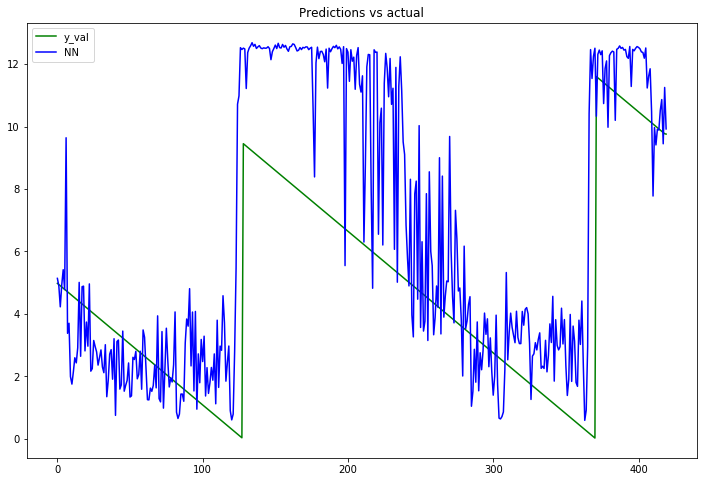

In [0]:
from sklearn.metrics import mean_absolute_error
y_pred_simplenn = model_nn.predict(X_val_sc)
val_error_simplenn = mean_absolute_error(y_val_sc, y_pred_simplenn)
print("Neural Network", val_error_simplenn)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(np.array(y_val_sc), color='g', label='y_val')
plt.plot(y_pred_simplenn, color='blue', label='NN')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### まとめ

LSTM 1.9942324285240565
GRU 2.3258658459083916
Neural Network 2.420472935904883


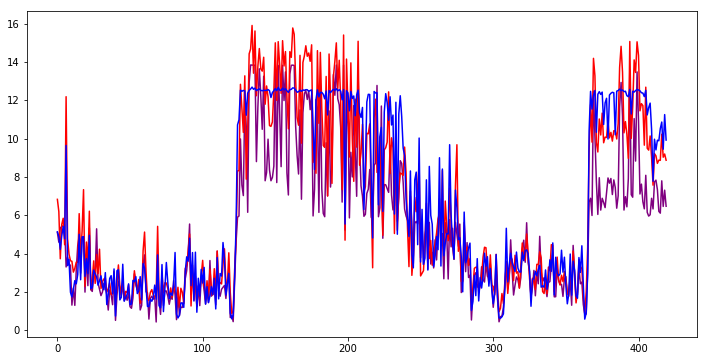

In [0]:
print("LSTM", val_error_lstm)
print("GRU", val_error_gru)
print("Neural Network", val_error_simplenn)

plt.figure(figsize=(12,6))
plt.plot(y_pred_lstm, color='purple', label='lstm')
plt.plot(y_pred_gru, color='red', label='gru')
plt.plot(y_pred_simplenn, color='blue', label='NN')
plt.plot(np.stack%)

plt.show()



**考察**<br>
* モデルは地震発生後はTTFが増加し、振れ幅はあれど減少方向に向かうことは学習できている。
* 地震発生に近づくにつれて誤差は小さくなっているように見受けられる。
* しかしやはりまだ地震発生直後（リセット後）のTTFの予測が外れると、そこからは修正できず、結果誤差が大きくなってしまっている。
* 上方向にズレた時は一定の値以下に抑えられているが、下方向にズレた時は対処できていない。

In [0]:
!unzip test.zip

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()
X_test_max={}

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'], thresholds=precursor_thresholds)
    X_test = X_test.append(ch, ignore_index=True)

X_test_sc = sc.fit_transform(X_test)
    
print(X_test.shape)
print(sub.shape)

(39360, 32)
(2624, 1)


In [0]:
X_test_reshaped = np.reshape(np.array(X_test_sc), (X_test.shape[0], 1, X_test.shape[1]))

pred_lstm = model_lstm.predict(X_test_reshaped)
pred_gru = model_gru.predict(X_test_reshaped)
pred_nn = model_nn.predict(X_test_sc)

pred_blend =pred_blend_min = np.stack([np.reshape(pred_lstm, (pred_lstm.shape[0],)), np.reshape(pred_gru, (pred_gru.shape[0],)), pred_nn], axis=1).mean(axis=1)

plt.figure(figsize=(12, 8))
plt.plot(pred_lstm[:100], color='purple', label='LSTM')
plt.plot(pred_gru[:100], color='red', label='GRU')
plt.plot(pred_nn[:100], color='blue', label='NeuralNet')
plt.plot(pred_blend[:100], color='green', label='Blend')
plt.legend()
plt.title('Predictions')
plt.show()

In [0]:
submission['time_to_failure'] = pred_y
submission.to_csv('submission_tnb.csv')

In [0]:
sub_df = pd.read_csv('submission_rnn.csv')
sub_df.head()

,seg_id,time_to_failure
0,seg_00030f,4.975380
1,seg_0012b5,4.032060
2,seg_00184e,5.744460
3,seg_003339,5.889573
4,seg_0042cc,6.054456


In [0]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission_birnn.csv -m "190501_bidirectional rnn"

100% 52.5k/52.5k [00:01<00:00, 33.3kB/s]
Successfully submitted to LANL Earthquake Prediction